# Obligatorio de Deep Learning: Detección de actividad anormal en logs de HDFS

Federico De León  
Daniel Dominitz  
Juan Emilio Gabito (138616)

## 1. Setup

### Imports

In [1]:
# Si estamos en Colab setemos Drive como FS
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Para Colab nos paramos en alguna de las carpetas del grupo
import os
if os.path.exists("/content/drive/MyDrive/ORT/DeepLearning/Obligatorio"):
  os.chdir('/content/drive/MyDrive/ORT/DeepLearning/Obligatorio')
else:
  if os.path.exists("/content/drive/MyDrive/ORT/Posgrado AI/Taller DeepLearning/Obligatorio"):
    os.chdir("/content/drive/MyDrive/ORT/Posgrado AI/Taller DeepLearning/Obligatorio")

In [74]:
import numpy as np
import datetime as dt
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Embedding, LSTM, Dense, BatchNormalization
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from importlib import reload
import utils
utils = reload(utils)

import pandas as pd

### Reproducibilidad y repetibilidad

Para poder asegurar la reproducibilidad y repetibilidad de los experimentos en distintas ejecuciones seteamos la _seed_ tanto en Numpy como en Tensorflow.

In [5]:
np.random.seed(117)
tf.random.set_seed(117)

## 2. Carga de datos

In [75]:
hdfs_train, hdfs_test_kaggle = utils.read_data()

In [76]:
hdfs_train[:4]

,id,sequence,class
0,0,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...",normal
2,2,"(21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...",normal
3,3,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal


In [77]:
hdfs_test_kaggle[:5]

,id,sequence
0,0,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25)"
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,..."
2,2,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,..."
3,3,"(4, 4, 4, 21, 10, 8, 10, 8, 25, 25, 25, 10, 8,..."
4,4,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,..."


## 3. Análisis exploratorio de datos

### Análisis descriptivo general

In [78]:
hdfs_train.head()

,id,sequence,class
0,0,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...",normal
2,2,"(21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...",normal
3,3,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
4,4,"(21, 4, 4, 4, 25, 25, 25, 10, 8, 10, 8, 10, 8,...",normal


In [ ]:
LABELS = ['Normal', 'Abnormal']

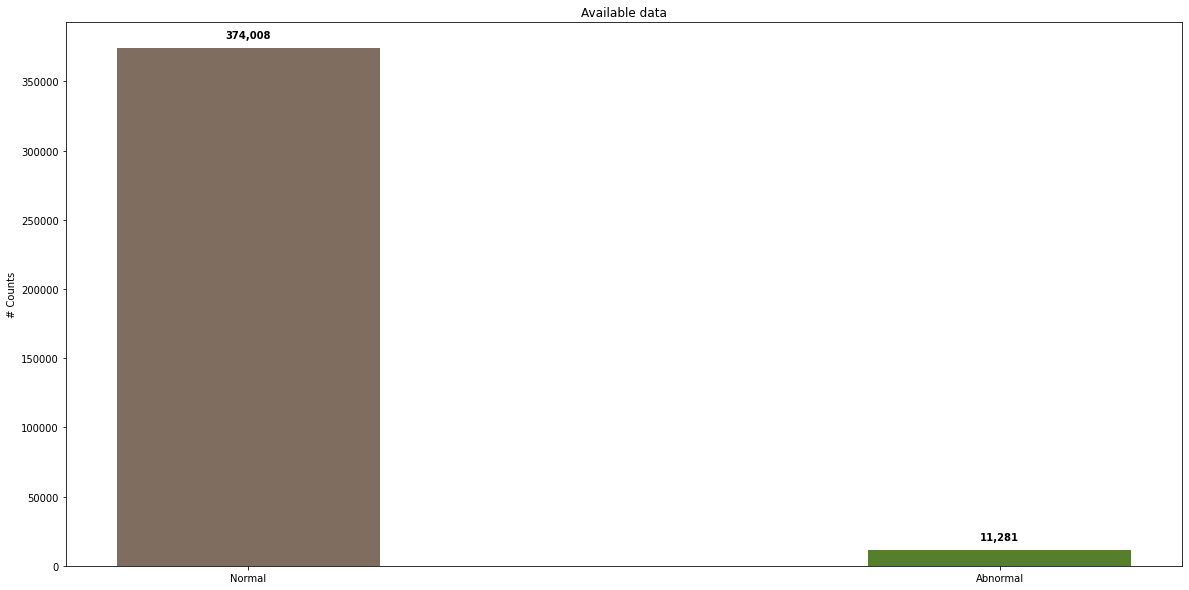

In [79]:
utils.plot_data(hdfs_train, LABELS, "Datos disponibles")

### Análisis de secuencias

In [16]:
#Agregar ploteo de largos de secuencias, distribuciones por simbolo, etc.

In [80]:
raw_sequences, data_y = utils.load_sequences_and_target(hdfs_train, one_hot=True)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [81]:
data_y.value_counts()

0    1  
0.0  1.0    374008
1.0  0.0     11281
dtype: int64

In [13]:
min([min(s) for s in raw_sequences])

1

In [14]:
max([max(s) for s in raw_sequences])

28

In [15]:
np.median([len(s) for s in raw_sequences])

19.0

In [ ]:
# Deberíamos agregar la mean también

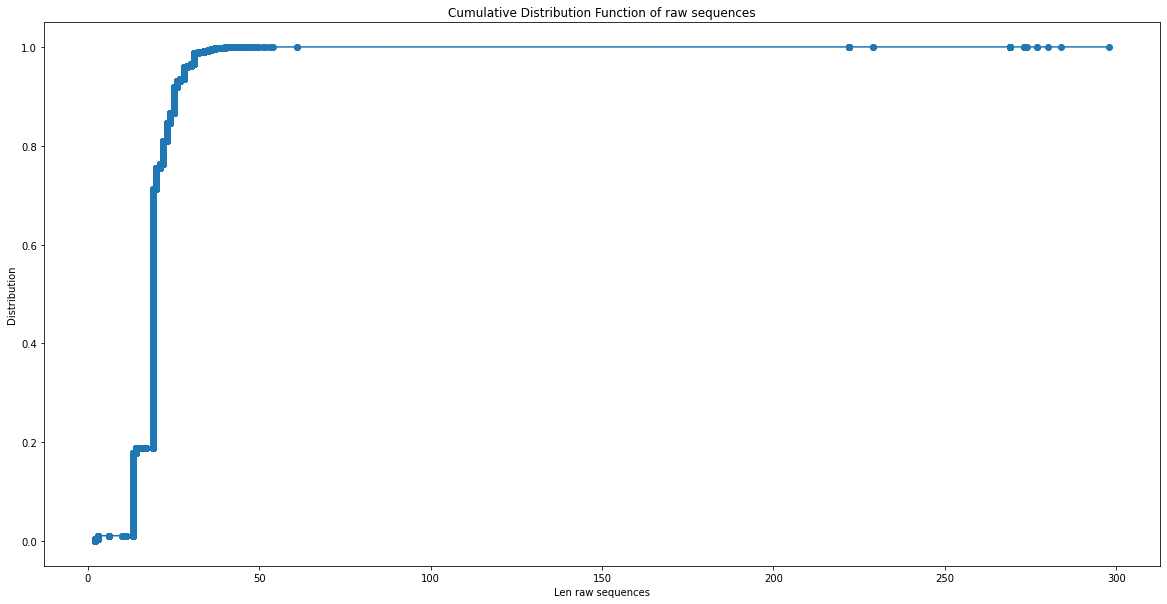

In [56]:
# Esto no tengo ni idea qué es. ¿Qué aporta? ¿Es parte del EDA?
# get the cdf values of the len
y = np.arange(len([len(s) for s in raw_sequences])) / float(len([len(s) for s in raw_sequences]))

#fig size
plt.figure(figsize=(20,10)) 
#labels
plt.xlabel('Len raw sequences')
plt.ylabel('Distribution')
#title
plt.title('Cumulative Distribution Function of raw sequences')  
#plot 
plt.plot(np.sort([len(s) for s in raw_sequences]), y, marker='o')

# Preprocesamiento de los datos

Previo a realizar el preprocesamiento de los datos y el posterior entrenamiento y evaluación se los modelos setearemos la constante
_MAX\_LEN_ en 19. Este valor se obtuvo del largo promedio de las secuencias y en base a experimentación con
tamaños maores y menores se pudo ver que 19 ofrecía los mejores resultados.

In [ ]:
MAX_LEN = 19

## Padding

In [82]:
padded_sequences = utils.pad_sequences(raw_sequences, MAX_LEN)

## Particionamiento

In [46]:
X_train, X_test, X_val, y_train, y_test, y_val = utils.split(padded_sequences, data_y)

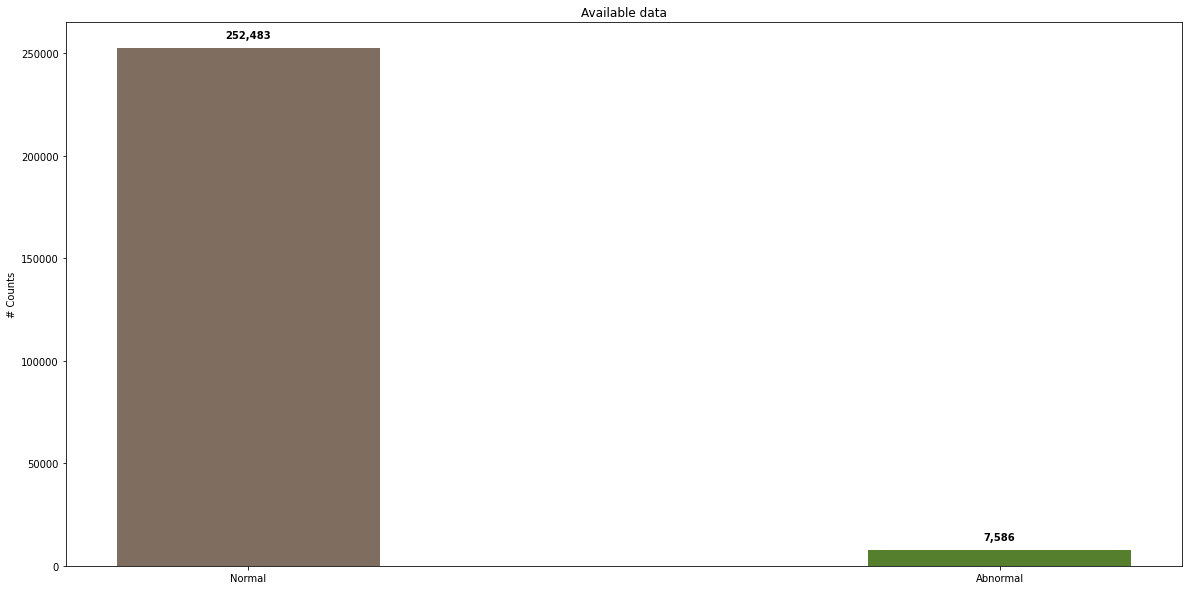

In [50]:

utils.plot_data(y_train, LABELS, "Datos de entrenamiento por clase", has_class=False)


## Generación de datos con Data Augmentation

In [51]:
X_train_for_aug, dummy_a, dummy_b, dummy_c, dummy_d, dummy_e = utils.split(raw_sequences, data_y)

In [52]:
X_train_aug, y_train_aug = utils.sequences_augmentation(X_train_for_aug, y_train, MAX_LEN, 19)

In [53]:
"""
padding to data augmentation traing
"""
X_train_aug = utils.pad_sequences(X_train_aug, MAX_LEN)

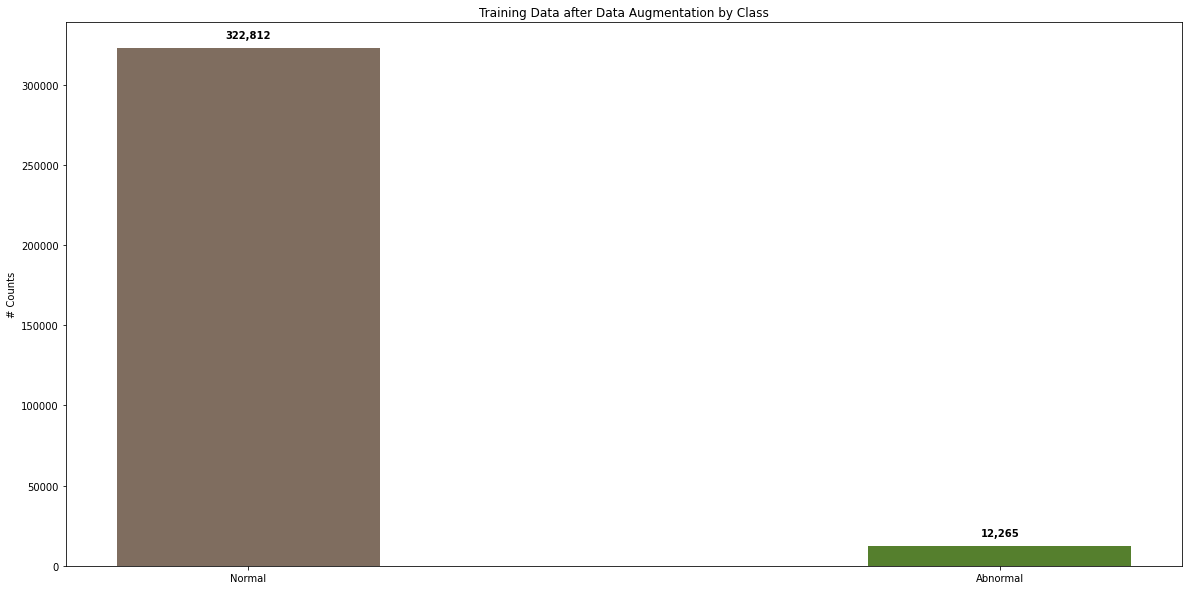

In [55]:
utils.plot_data(y_train_aug, LABELS, "Datos de entrenamiento luego de Data Augmentation por clase", has_class=False)

# Redes Neuronales Recurrentes

## Modelo Inicial

In [83]:
vocab_size = max([max(s) for s in raw_sequences]) + 1
batch_size = 10
epochs = 2
patience = 10
optimizer = Adam() 
loss = 'categorical_crossentropy'
embedding_size = math.ceil(vocab_size**0.25) 

### Truncating = 'Pre'

In [84]:
initial_model = Sequential()
initial_model.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
initial_model.add(LSTM(64, return_sequences=False))
initial_model.add(Dense(2, activation='softmax'))
initial_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
initial_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 19, 3)             90        
                                                                 
 lstm_1 (LSTM)               (None, 64)                17408     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 17,628
Trainable params: 17,628
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [85]:
#se agregó class.weights
initial_training, initial_model = utils.train(initial_model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/2
26007/26007 [==============================] - 251s 10ms/step - loss: 0.0477 - accuracy: 0.9932 - val_loss: 0.0070 - val_accuracy: 0.9988
Epoch 2/2
26007/26007 [==============================] - 258s 10ms/step - loss: 0.0159 - accuracy: 0.9984 - val_loss: 0.0150 - val_accuracy: 0.9989


#### Evaluación

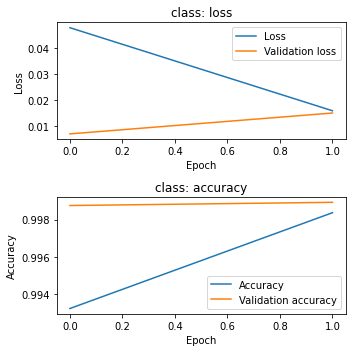

3011/3011 [==============================] - 13s 4ms/step


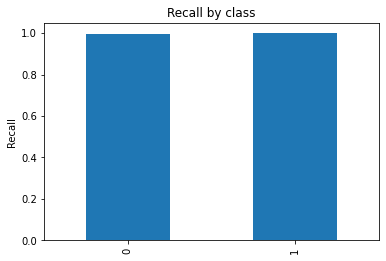

Classification report
              precision    recall  f1-score   support

    abnormal       0.97      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.98      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.0156711433082819, accuracy: 0.998733401298523


In [86]:
initialmodel_accuracy, initialmodel_precision, initialmodel_recall, initialmodel_f1 = utils.eval_model(initial_training, initial_model, X_test, y_test)

### Truncating = 'Post'

In [89]:
initial_model_post = Sequential()
initial_model_post.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
initial_model_post.add(LSTM(64, return_sequences=False))
initial_model_post.add(Dense(2, activation='softmax'))
initial_model_post.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
initial_model_post.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 19, 3)             90        
                                                                 
 lstm_2 (LSTM)               (None, 64)                17408     
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 17,628
Trainable params: 17,628
Non-trainable params: 0
_________________________________________________________________


#### Datos con padding al final

In [90]:
padded_sequences_post = utils.pad_sequences(raw_sequences, MAX_LEN,truncating='post')

In [91]:
X_train_post, X_test_post, X_val_post, y_train_post, y_test_post, y_val_post = utils.split(padded_sequences_post, data_y)

#### Entrenamiento

In [92]:
#se agregó class.weights
initial_training_post, initial_model_post = utils.train(initial_model_post,
                X_train_post,
                y_train_post, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val_post, 
                validation_data_y = y_val_post,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/2
26007/26007 [==============================] - 266s 10ms/step - loss: 0.2745 - accuracy: 0.9796 - val_loss: 0.1705 - val_accuracy: 0.9908
Epoch 2/2
26007/26007 [==============================] - 246s 9ms/step - loss: 0.2524 - accuracy: 0.9864 - val_loss: 0.1970 - val_accuracy: 0.9904


#### Evaluación

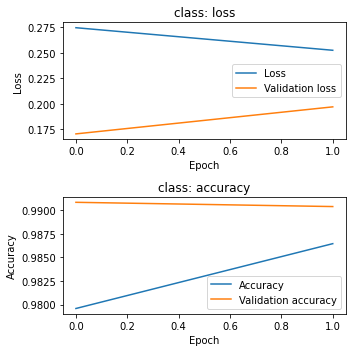

3011/3011 [==============================] - 12s 4ms/step


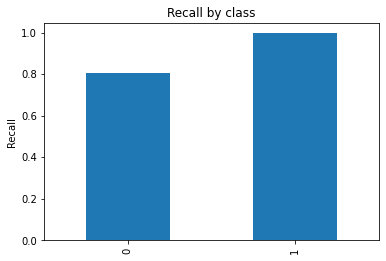

Classification report
              precision    recall  f1-score   support

    abnormal       0.87      0.81      0.84      2901
      normal       0.99      1.00      1.00     93422

    accuracy                           0.99     96323
   macro avg       0.93      0.90      0.92     96323
weighted avg       0.99      0.99      0.99     96323

Loss function: 0.19646018743515015, accuracy: 0.9905214905738831


In [93]:
initialmodel_post_accuracy, initialmodel_post_precision, initialmodel_post_recall, initialmodel_post_f1 = utils.eval_model(initial_training_post, initial_model_post, X_test_post, y_test_post)

### Comentarios padding

In [94]:
pd.options.display.float_format = '{:.3%}'.format
data = [['Initial Model Pre Truncating',initialmodel_accuracy, initialmodel_precision, initialmodel_recall, initialmodel_f1], ['Initial Model Post Truncating',initialmodel_post_accuracy, initialmodel_post_precision, initialmodel_post_recall, initialmodel_post_f1]]
pd.DataFrame(data, columns=["Modelo", "Accuracy", "Precision","Recall","F1-score"]).sort_values(by='F1-score', ascending=False)

,Modelo,Accuracy,Precision,Recall,F1-score
0,Initial Model Pre Truncating,99.873%,98.265%,99.617%,98.931%
1,Initial Model Post Truncating,99.052%,93.189%,90.109%,91.588%


## Modelo Mejorado

In [ ]:
vocab_size = max([max(s) for s in raw_sequences]) + 1
batch_size = 24
epochs = 7
patience = 10
optimizer = Adam() 
loss = 'categorical_crossentropy'
embedding_size = math.ceil(vocab_size**0.25) 

In [ ]:
improved_model = Sequential()
improved_model.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
improved_model.add(LSTM(64, return_sequences=True))
improved_model.add(LSTM(64, return_sequences=False))
improved_model.add(Dense(2, activation='softmax'))
improved_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
improved_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 19, 3)             90        
                                                                 
 lstm_1 (LSTM)               (None, 19, 64)            17408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 50,652
Trainable params: 50,652
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento

In [ ]:
#se agregó class.weights
improved_training, improved_model = utils.train(improved_model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/7
10837/10837 [==============================] - 157s 14ms/step - loss: 0.0464 - accuracy: 0.9922 - val_loss: 0.0078 - val_accuracy: 0.9989
Epoch 2/7
10837/10837 [==============================] - 156s 14ms/step - loss: 0.0173 - accuracy: 0.9974 - val_loss: 0.0105 - val_accuracy: 0.9988
Epoch 3/7
10837/10837 [==============================] - 156s 14ms/step - loss: 0.0124 - accuracy: 0.9985 - val_loss: 0.0048 - val_accuracy: 0.9988
Epoch 4/7
10837/10837 [==============================] - 155s 14ms/step - loss: 0.0136 - accuracy: 0.9986 - val_loss: 0.0060 - val_accuracy: 0.9988
Epoch 5/7
10837/10837 [==============================] - 157s 14ms/step - loss: 0.0109 - accuracy: 0.9987 - val_loss: 0.0044 - val_accuracy: 0.9992
Epoch 6/7
10837/10837 [==============================] - 160s 15ms/step - loss: 0.0095 - accuracy: 0.9988 - val_loss: 0.0063 - val_accuracy: 0.9988
Epoch 7/7
10837/10837 [==============================] - 161s 15ms/step - loss: 0.0087 - accuracy: 0.9990 - val_

### Evaluación

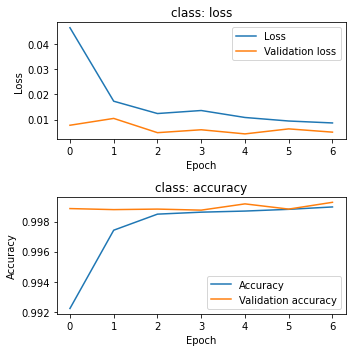

3011/3011 [==============================] - 15s 5ms/step


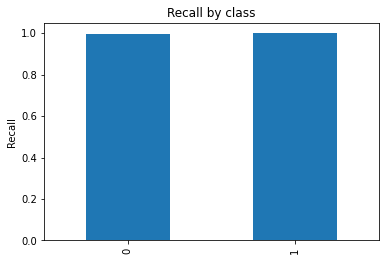

Classification report
              precision    recall  f1-score   support

    abnormal       0.98      0.99      0.99      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.99      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.00552724814042449, accuracy: 0.9991175532341003


In [ ]:
improved_model_accuracy, improved_model_precision, improved_model_recall, improved_model_f1 = utils.eval_model(improved_training, improved_model, X_test, y_test)

## Grid Search



In [ ]:
vocab_size = 30
patience = 5
embedding_size=3

params = {
    "batch_size": [16, 32],
    "epochs": [2, 8, 15],
    "units": [2,64, 72],
    "vocab_size": [vocab_size + 1,],
    "embedding_size": [embedding_size],
    "max_len": [MAX_LEN,],
    "optimizer": ["adam",],
    "loss": ["categorical_crossentropy",]
}

In [ ]:
"""
Entrenamiento
"""
gs = utils.grid_search(params, utils.build_improved_model, 3)
grid_result = gs.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/15
16255/16255 [==============================] - 249s 15ms/step - loss: 0.0243 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944
Epoch 2/15
16255/16255 [==============================] - 252s 16ms/step - loss: 0.0051 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988
Epoch 3/15
16255/16255 [==============================] - 247s 15ms/step - loss: 0.0026 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993
Epoch 4/15
16255/16255 [==============================] - 246s 15ms/step - loss: 0.0020 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996
Epoch 5/15
16255/16255 [==============================] - 249s 15ms/step - loss: 0.0018 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996
Epoch 6/15
16255/16255 [==============================] - 248s 15ms/step - loss: 0.0017 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997
Epoch 7/15
16255/16255 [==============================] - 249s 15ms/step - loss: 0.0016 - accuracy: 0.9997 - precision: 0.9997 - recall:

In [ ]:
grid_result.best_params_ #comentar que tambien se puede obtener el best model que en definitiva es lo mismo que hacemos en Modelo Mejorado

In [ ]:
batch_size = grid_result.best_params_['vocab_size']
epochs = grid_result.best_params_['epochs']
units = grid_result.best_params_['units']
optimizer = Adam() 
loss = grid_result.best_params_['loss']

### Model Mejorado 

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
model.add(LSTM(units, return_sequences=True))
model.add(LSTM(units, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_5 (LSTM)               (None, 19, 64)            17408     
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 50,655
Trainable params: 50,655
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [ ]:
#se agregó class.weights
training, model = utils.train(model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
8390/8390 [==============================] - 153s 18ms/step - loss: 0.0529 - accuracy: 0.9911 - precision_1: 0.9911 - recall_1: 0.9911 - val_loss: 0.0105 - val_accuracy: 0.9988 - val_precision_1: 0.9988 - val_recall_1: 0.9988
Epoch 2/15
8390/8390 [==============================] - 151s 18ms/step - loss: 0.0206 - accuracy: 0.9974 - precision_1: 0.9974 - recall_1: 0.9974 - val_loss: 0.0131 - val_accuracy: 0.9988 - val_precision_1: 0.9988 - val_recall_1: 0.9988
Epoch 3/15
8390/8390 [==============================] - 152s 18ms/step - loss: 0.0130 - accuracy: 0.9983 - precision_1: 0.9983 - recall_1: 0.9983 - val_loss: 0.0064 - val_accuracy: 0.9987 - val_precision_1: 0.9987 - val_recall_1: 0.9987
Epoch 4/15
8390/8390 [==============================] - 151s 18ms/step - loss: 0.0113 - accuracy: 0.9986 - precision_1: 0.9986 - recall_1: 0.9986 - val_loss: 0.0126 - val_accuracy: 0.9984 - val_precision_1: 0.9984 - val_recall_1: 0.9984
Epoch 5/15
8390/8390 [==============================

#### Evaluación

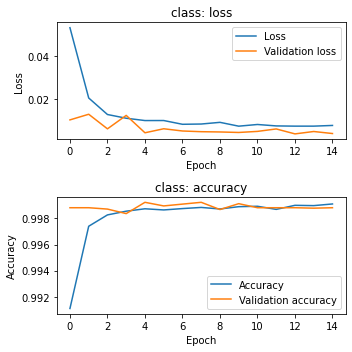

3011/3011 [==============================] - 18s 6ms/step


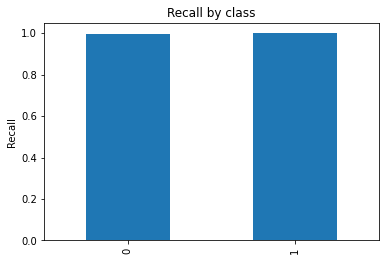

Classification report
              precision    recall  f1-score   support

    abnormal       0.98      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.99      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.004978092387318611, accuracy: 0.9990760087966919


In [ ]:
model_accuracy, model_precision, model_recall, model_f1 = utils.eval_model(training, model, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='model'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(model, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = model.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 34s 6ms/step
Saved model to disk


### Modelo Mejorado con Batch Normalization

In [ ]:
modelBN = Sequential()
modelBN.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelBN.add(LSTM(units, return_sequences=True))
modelBN.add(LSTM(units, return_sequences=False))
modelBN.add(BatchNormalization())
modelBN.add(Dense(2, activation='softmax'))
modelBN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelBN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_7 (LSTM)               (None, 19, 64)            17408     
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 50,911
Trainable params: 50,783
Non-trainable params: 128
________________________________________________

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingBN, modelBN = utils.train(modelBN,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
8390/8390 [==============================] - 156s 18ms/step - loss: 0.0310 - accuracy: 0.9946 - precision_2: 0.9946 - recall_2: 0.9946 - val_loss: 0.0162 - val_accuracy: 0.9989 - val_precision_2: 0.9989 - val_recall_2: 0.9989
Epoch 2/15
8390/8390 [==============================] - 149s 18ms/step - loss: 0.0178 - accuracy: 0.9981 - precision_2: 0.9981 - recall_2: 0.9981 - val_loss: 0.1607 - val_accuracy: 0.9917 - val_precision_2: 0.9917 - val_recall_2: 0.9917
Epoch 3/15
8390/8390 [==============================] - 150s 18ms/step - loss: 0.0153 - accuracy: 0.9982 - precision_2: 0.9982 - recall_2: 0.9982 - val_loss: 0.0094 - val_accuracy: 0.9991 - val_precision_2: 0.9991 - val_recall_2: 0.9991
Epoch 4/15
8390/8390 [==============================] - 148s 18ms/step - loss: 0.0150 - accuracy: 0.9983 - precision_2: 0.9983 - recall_2: 0.9983 - val_loss: 0.0878 - val_accuracy: 0.9812 - val_precision_2: 0.9812 - val_recall_2: 0.9812
Epoch 5/15
8390/8390 [==============================

#### Evaluación

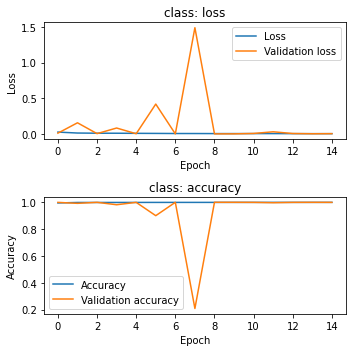

3011/3011 [==============================] - 17s 5ms/step


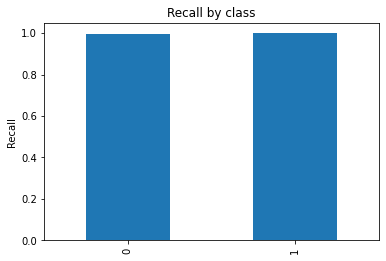

Classification report
              precision    recall  f1-score   support

    abnormal       0.96      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.98      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.010023570619523525, accuracy: 0.9986711144447327


In [ ]:
modelBN_accuracy, modelBN_precision, modelBN_recall, modelBN_f1 = utils.eval_model(trainingBN, modelBN, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithBN'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(modelBN, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelBN.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelBN.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 31s 5ms/step
Saved model to disk


### Modelo Mejorado con Gradient Clipping


In [ ]:
optimizer = Adam(clipvalue=0.5) #para agregar clip value clipvalue=0.5

In [ ]:
modelGC = Sequential()
modelGC.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelGC.add(LSTM(units, return_sequences=True))
modelGC.add(LSTM(units, return_sequences=False))
modelGC.add(Dense(2, activation='softmax'))
modelGC.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelGC.summary()

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingGC, modelGC = utils.train(modelGC,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

#### Evaluación

In [ ]:
modelGC_accuracy, modelGC_precision, modelGC_recall, modelGC_f1 = utils.eval_model(trainingGC, modelGC, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithGC'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(modelGC, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGC.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGC.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")


### Modelo Mejorado con Gradient *Normalization*




In [ ]:
optimizer = Adam(clipnorm=1.) #para agregar clip value clipvalue=0.5

In [ ]:
modelGN = Sequential()
modelGN.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelGN.add(LSTM(units, return_sequences=True))
modelGN.add(LSTM(units, return_sequences=False))
modelGN.add(Dense(2, activation='softmax'))
modelGN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelGN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_9 (LSTM)               (None, 19, 64)            17408     
                                                                 
 lstm_10 (LSTM)              (None, 64)                33024     
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 50,655
Trainable params: 50,655
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingGN, modelGN = utils.train(modelGN,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
8390/8390 [==============================] - 150s 17ms/step - loss: 0.1289 - accuracy: 0.9821 - precision_3: 0.9821 - recall_3: 0.9821 - val_loss: 0.0141 - val_accuracy: 0.9980 - val_precision_3: 0.9980 - val_recall_3: 0.9980
Epoch 2/15
8390/8390 [==============================] - 146s 17ms/step - loss: 0.0321 - accuracy: 0.9978 - precision_3: 0.9978 - recall_3: 0.9978 - val_loss: 0.0141 - val_accuracy: 0.9974 - val_precision_3: 0.9974 - val_recall_3: 0.9974
Epoch 3/15
8390/8390 [==============================] - 146s 17ms/step - loss: 0.0288 - accuracy: 0.9983 - precision_3: 0.9983 - recall_3: 0.9983 - val_loss: 0.0083 - val_accuracy: 0.9987 - val_precision_3: 0.9987 - val_recall_3: 0.9987
Epoch 4/15
8390/8390 [==============================] - 146s 17ms/step - loss: 0.0221 - accuracy: 0.9986 - precision_3: 0.9986 - recall_3: 0.9986 - val_loss: 0.0085 - val_accuracy: 0.9990 - val_precision_3: 0.9990 - val_recall_3: 0.9990
Epoch 5/15
8390/8390 [==============================

#### Evaluación

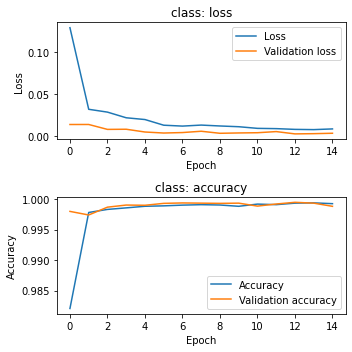

3011/3011 [==============================] - 17s 5ms/step


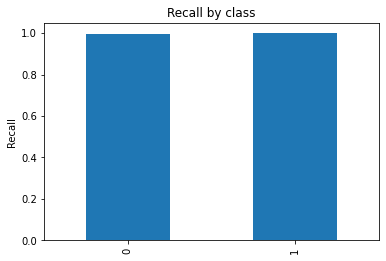

Classification report
              precision    recall  f1-score   support

    abnormal       0.96      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.98      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.004350789822638035, accuracy: 0.9986711144447327


In [ ]:
modelGN_accuracy, modelGN_precision, modelGN_recall, modelGN_f1 = utils.eval_model(trainingGN, modelGN, X_test, y_test)

####Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithGN'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(modelGN, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGN.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGN.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")


5931/5931 [==============================] - 33s 6ms/step
Saved model to disk


### Modelo Mejorado con Batch Normalization y Gradient Normalization

In [ ]:
modelGN_BN = Sequential()
modelGN_BN.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelGN_BN.add(LSTM(units, return_sequences=True))
modelGN_BN.add(LSTM(units, return_sequences=False))
modelGN_BN.add(BatchNormalization())
modelGN_BN.add(Dense(2, activation='softmax'))
modelGN_BN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelGN_BN.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_11 (LSTM)              (None, 19, 64)            17408     
                                                                 
 lstm_12 (LSTM)              (None, 64)                33024     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 2)                 130       
                                                                 
Total params: 50,911
Trainable params: 50,783
Non-trainable params: 128
________________________________________________

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingGN_BN, modelGN_BN = utils.train(modelGN_BN,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
8390/8390 [==============================] - 152s 18ms/step - loss: 0.0264 - accuracy: 0.9979 - precision_4: 0.9979 - recall_4: 0.9979 - val_loss: 6.8521 - val_accuracy: 0.0364 - val_precision_4: 0.0364 - val_recall_4: 0.0364
Epoch 2/15
8390/8390 [==============================] - 148s 18ms/step - loss: 0.0276 - accuracy: 0.9991 - precision_4: 0.9991 - recall_4: 0.9991 - val_loss: 8.9719 - val_accuracy: 0.2049 - val_precision_4: 0.2049 - val_recall_4: 0.2049
Epoch 3/15
8390/8390 [==============================] - 148s 18ms/step - loss: 0.0272 - accuracy: 0.9992 - precision_4: 0.9992 - recall_4: 0.9992 - val_loss: 0.0117 - val_accuracy: 0.9964 - val_precision_4: 0.9964 - val_recall_4: 0.9964
Epoch 4/15
8390/8390 [==============================] - 148s 18ms/step - loss: 0.0235 - accuracy: 0.9991 - precision_4: 0.9991 - recall_4: 0.9991 - val_loss: 0.0090 - val_accuracy: 0.9988 - val_precision_4: 0.9988 - val_recall_4: 0.9988
Epoch 5/15
8390/8390 [==============================

#### Evaluación

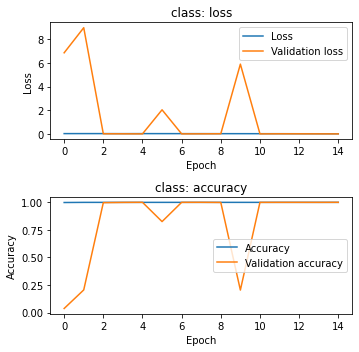

3011/3011 [==============================] - 16s 5ms/step


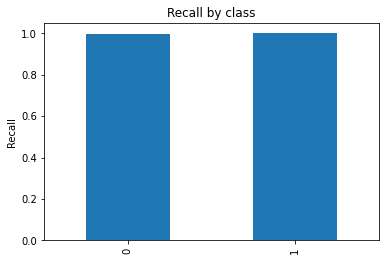

Classification report
              precision    recall  f1-score   support

    abnormal       0.99      0.99      0.99      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       1.00      1.00      1.00     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.004058150574564934, accuracy: 0.9995743632316589


In [ ]:
modelGN_BN_accuracy, modelGN_BN_precision, modelGN_BN_recall, modelGN_BN_f1 = utils.eval_model(trainingGN_BN, modelGN_BN, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithGNandBN'

"""
Generate data Kaggle
"""

utils.load_test_sequences_and_generate_prediction_file(modelGN_BN, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGN_BN.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGN_BN.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 30s 5ms/step
Saved model to disk


### Modelo Mejorado con Data Augmentation

In [ ]:
modelDA = Sequential()
modelDA.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelDA.add(LSTM(units, return_sequences=True))
modelDA.add(LSTM(units, return_sequences=False))
modelDA.add(Dense(2, activation='softmax'))
modelDA.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelDA.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_13 (LSTM)              (None, 19, 64)            17408     
                                                                 
 lstm_14 (LSTM)              (None, 64)                33024     
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                                 
Total params: 50,655
Trainable params: 50,655
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingDA, modelDA = utils.train(modelDA,
                X_train_aug,
                y_train_aug, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
10809/10809 [==============================] - 189s 17ms/step - loss: 0.0779 - accuracy: 0.9911 - precision_5: 0.9911 - recall_5: 0.9911 - val_loss: 0.0081 - val_accuracy: 0.9989 - val_precision_5: 0.9989 - val_recall_5: 0.9989
Epoch 2/15
10809/10809 [==============================] - 185s 17ms/step - loss: 0.0284 - accuracy: 0.9983 - precision_5: 0.9983 - recall_5: 0.9983 - val_loss: 0.0054 - val_accuracy: 0.9992 - val_precision_5: 0.9992 - val_recall_5: 0.9992
Epoch 3/15
10809/10809 [==============================] - 186s 17ms/step - loss: 0.0236 - accuracy: 0.9985 - precision_5: 0.9985 - recall_5: 0.9985 - val_loss: 0.0085 - val_accuracy: 0.9988 - val_precision_5: 0.9988 - val_recall_5: 0.9988
Epoch 4/15
10809/10809 [==============================] - 186s 17ms/step - loss: 0.0212 - accuracy: 0.9982 - precision_5: 0.9982 - recall_5: 0.9982 - val_loss: 0.0071 - val_accuracy: 0.9982 - val_precision_5: 0.9982 - val_recall_5: 0.9982
Epoch 5/15
10809/10809 [====================

#### Evaluación

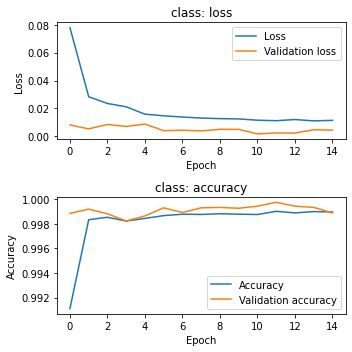

3011/3011 [==============================] - 16s 5ms/step


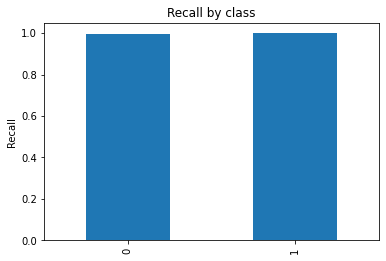

Classification report
              precision    recall  f1-score   support

    abnormal       0.96      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.98      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.004865689668804407, accuracy: 0.9987126588821411


In [ ]:
modelDA_accuracy, modelDA_precision, modelDA_recall, modelDA_f1 = utils.eval_model(trainingDA, modelDA, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithDataAugmentation'

"""
Generate data Kaggle
"""

utils.load_test_sequences_and_generate_prediction_file(modelDA, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelDA.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelDA.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 30s 5ms/step
Saved model to disk


### Modelo Mejorado con Data Augmentation y Gradient Normalization 

In [ ]:
optimizer = Adam(clipnorm=1.) #para agregar clip value clipvalue=0.5

In [ ]:
modelGN_DA = Sequential()
modelGN_DA.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN)) 
modelGN_DA.add(LSTM(units, return_sequences=True))
modelGN_DA.add(LSTM(units, return_sequences=False))
modelGN_DA.add(Dense(2, activation='softmax'))
modelGN_DA.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelGN_DA.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_15 (LSTM)              (None, 19, 64)            17408     
                                                                 
 lstm_16 (LSTM)              (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 2)                 130       
                                                                 
Total params: 50,655
Trainable params: 50,655
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [ ]:
trainingGN_DA, modelGN_DA = utils.train(modelGN_DA,
                X_train_aug,
                y_train_aug, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
10809/10809 [==============================] - 189s 17ms/step - loss: 0.0896 - accuracy: 0.9869 - precision_6: 0.9869 - recall_6: 0.9869 - val_loss: 0.0108 - val_accuracy: 0.9976 - val_precision_6: 0.9976 - val_recall_6: 0.9976
Epoch 2/15
10809/10809 [==============================] - 184s 17ms/step - loss: 0.0280 - accuracy: 0.9979 - precision_6: 0.9979 - recall_6: 0.9979 - val_loss: 0.0062 - val_accuracy: 0.9994 - val_precision_6: 0.9994 - val_recall_6: 0.9994
Epoch 3/15
10809/10809 [==============================] - 186s 17ms/step - loss: 0.0223 - accuracy: 0.9985 - precision_6: 0.9985 - recall_6: 0.9985 - val_loss: 0.0074 - val_accuracy: 0.9989 - val_precision_6: 0.9989 - val_recall_6: 0.9989
Epoch 4/15
10809/10809 [==============================] - 186s 17ms/step - loss: 0.0186 - accuracy: 0.9984 - precision_6: 0.9984 - recall_6: 0.9984 - val_loss: 0.0037 - val_accuracy: 0.9993 - val_precision_6: 0.9993 - val_recall_6: 0.9993
Epoch 5/15
10809/10809 [====================

#### Evaluación

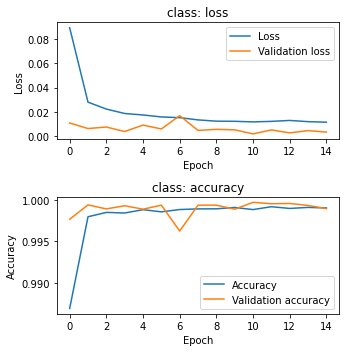

3011/3011 [==============================] - 19s 5ms/step


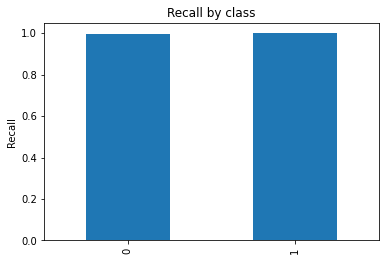

Classification report
              precision    recall  f1-score   support

    abnormal       0.97      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.98      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.0031659677624702454, accuracy: 0.9988787770271301


In [ ]:
modelGN_DA_accuracy, modelGN_DA_precision, modelGN_DA_recall, modelGN_DA_f1 = utils.eval_model(trainingGN_DA, modelGN_DA, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithDataAugmentationAndGradientNormalization'

"""
Generate data Kaggle
"""

utils.load_test_sequences_and_generate_prediction_file(modelGN_DA, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGN_DA.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGN_DA.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 31s 5ms/step
Saved model to disk


## Conclusiones y reflexiones finales

## Bibliogafìía y referencias